## Import Libraries

In [22]:
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Load & Display Images

In [23]:
# Initialize the video capture
capture = cv2.VideoCapture(0)
# Create an empty list to store the frames
images = []
while True:
    # Capture a frame
    ret, frame = capture.read()
    
    
    # Check if the frame was captured successfully
    if not ret:
        break
    
    # Append the frame to the list of images
    images.append(frame)
    
    # Display the captured frame
    cv2.imshow("Live Image", frame)
    
    # Check if the 'q' key was pressed to stop capturing frames
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture
capture.release()
cv2.destroyAllWindows()


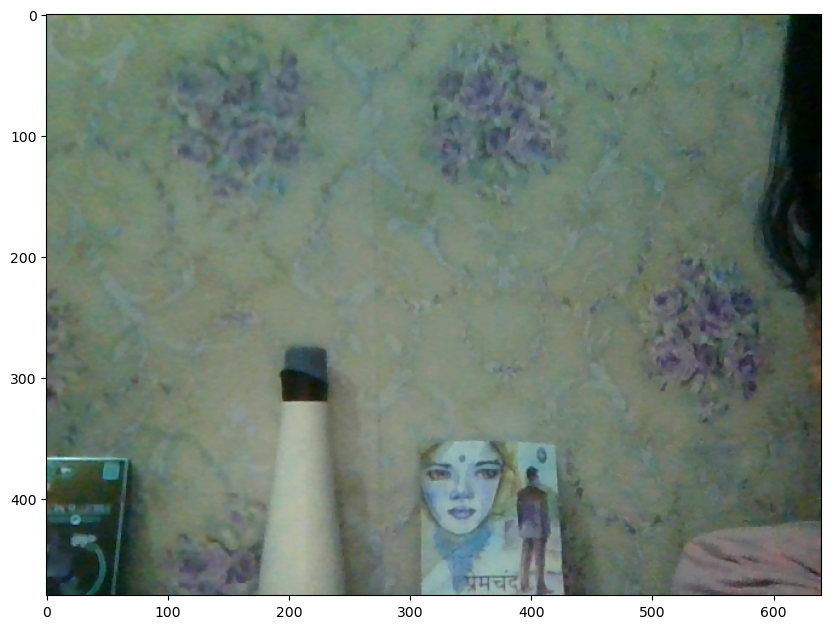

In [24]:
# Display one image
plt.figure(figsize=(10,10))
plt.imshow(images[50])

## Extract Features

In [25]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints = []  # List to store keypoints for each image
descriptors = []  # List to store descriptors for each image

for image in images:
    # Find keypoints and descriptors for the current image
    kp, des = sift.detectAndCompute(image, None)
    
    # Store keypoints and descriptors for the current image
    keypoints.append(kp)
    descriptors.append(des)

In [26]:
kp_images = []
index = 0
for image in images:
    kp_image = cv2.drawKeypoints(image, keypoints[index], None)
    index = index+1
    kp_images.append(kp_image)

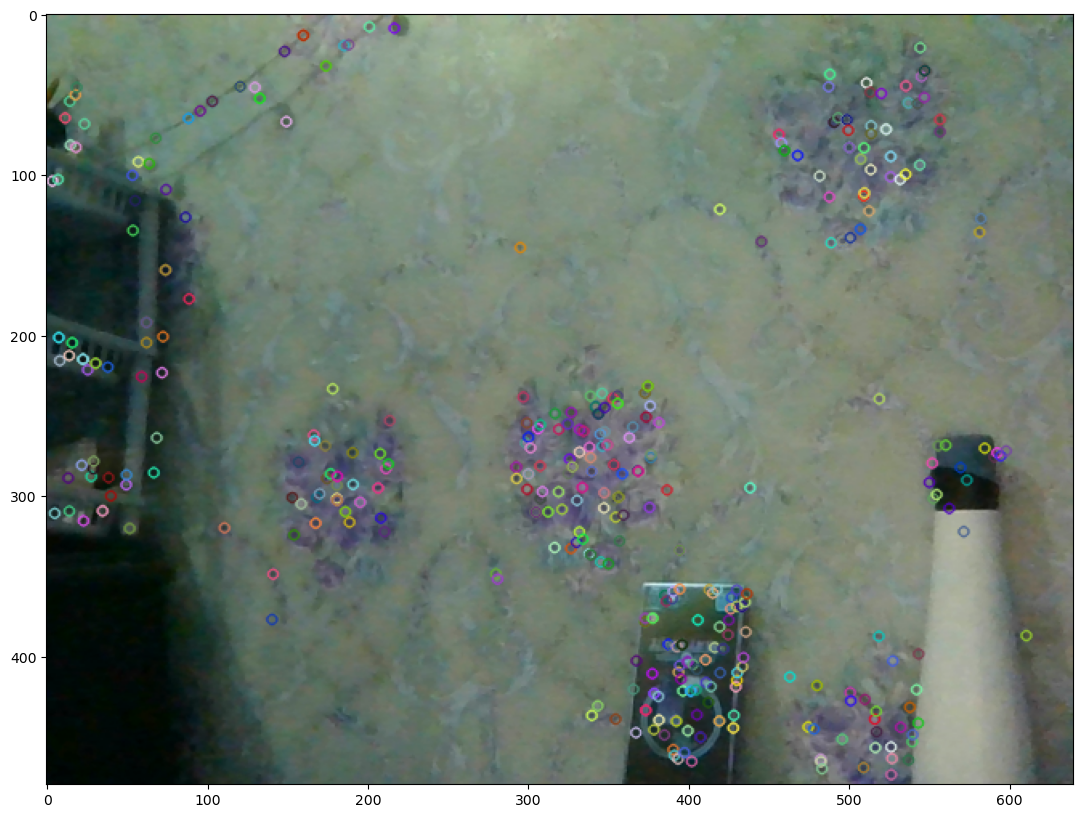

In [27]:
plt.figure(figsize=(15,10))
plt.imshow(kp_images[0])

## Draw Matches

In [28]:
ratio = 0.85
min_match = 10

matcher = cv2.BFMatcher()
#raw_matches = matcher.knnMatch(des1, des2, k=2)
raw_matches = matcher.knnMatch(descriptors[0], descriptors[1], k=2)
good_points = []
good_matches = []
for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])
matches = cv2.drawMatchesKnn(images[0], keypoints[0], images[1], keypoints[1], good_matches, None, flags=2)

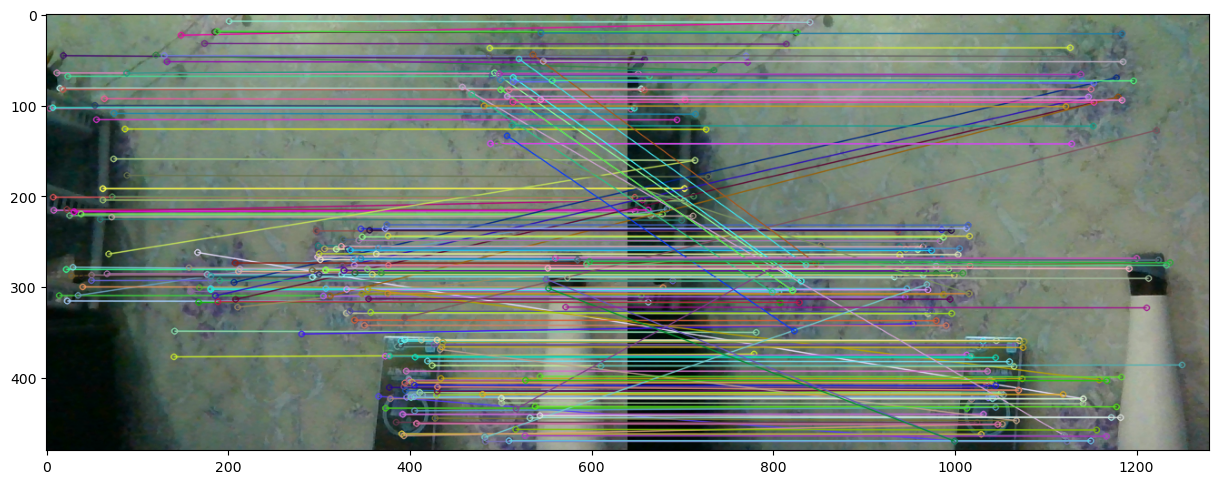

In [29]:
plt.figure(figsize=(15,10))
plt.imshow(matches)

## Find Homography using RANSAC

In [30]:
kp1=keypoints[0]
kp2=keypoints[1]
if len(good_points) > min_match:
    image1_kp = np.float32(
        [kp1[i].pt for (_, i) in good_points])
    image2_kp = np.float32(
        [kp2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)      # RANSAC

## Stitch and Blend

In [31]:
def create_mask(img1,img2,version, smoothing_window_size):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

In [32]:
smoothing_window_size = 400
height_img1 = images[0].shape[0]
width_img1 = images[0].shape[1]
width_img2 = images[1].shape[1]
height_panorama = height_img1
width_panorama = width_img1 + width_img2

In [33]:
panorama1 = np.zeros((height_panorama, width_panorama, 3))
panorama1.shape[1]

1280

In [34]:
mask1 = create_mask(images[0], images[1], version='left_image', smoothing_window_size=smoothing_window_size)
 

In [35]:
panorama1[0:images[0].shape[0], 0:images[0].shape[1], :] = images[0]
panorama1 *= mask1
mask2 = create_mask(images[0],images[1],version='right_image', smoothing_window_size=smoothing_window_size)
panorama2 = cv2.warpPerspective(images[1], H, (width_panorama, height_panorama))*mask2
result = panorama1 + panorama2

rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]

In [36]:
test = cv2.warpPerspective(images[1], H, (width_panorama, height_panorama))

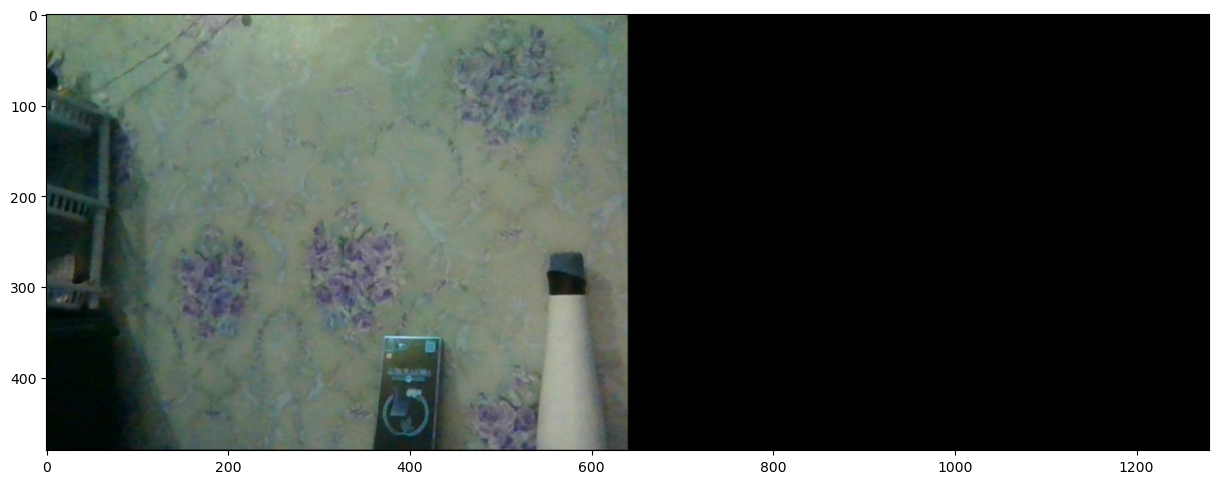

In [37]:
plt.figure(figsize=(15,10))
plt.imshow(test/255.0)

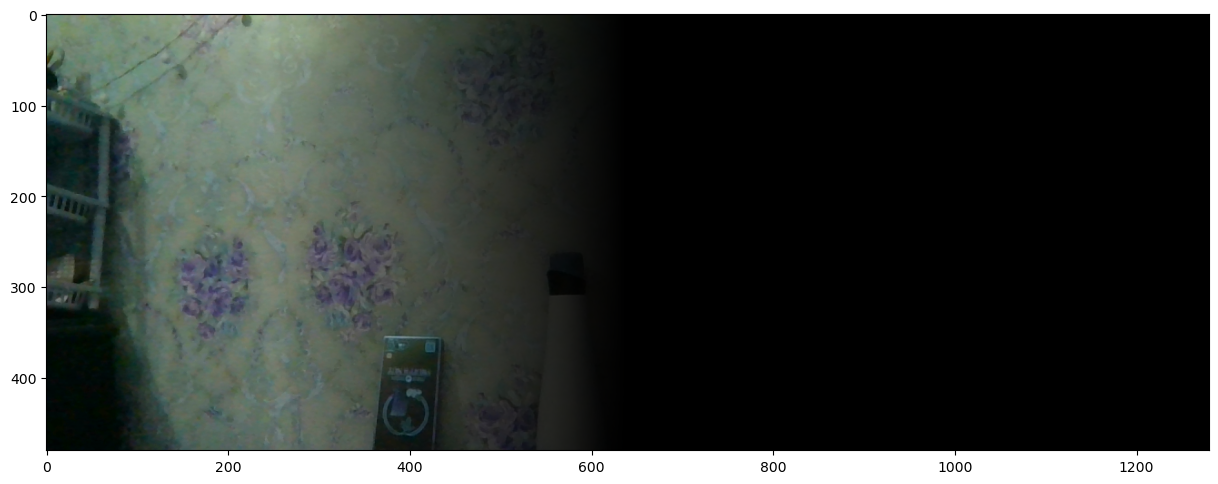

In [38]:
plt.figure(figsize=(15,10))
plt.imshow(panorama1/255.0)

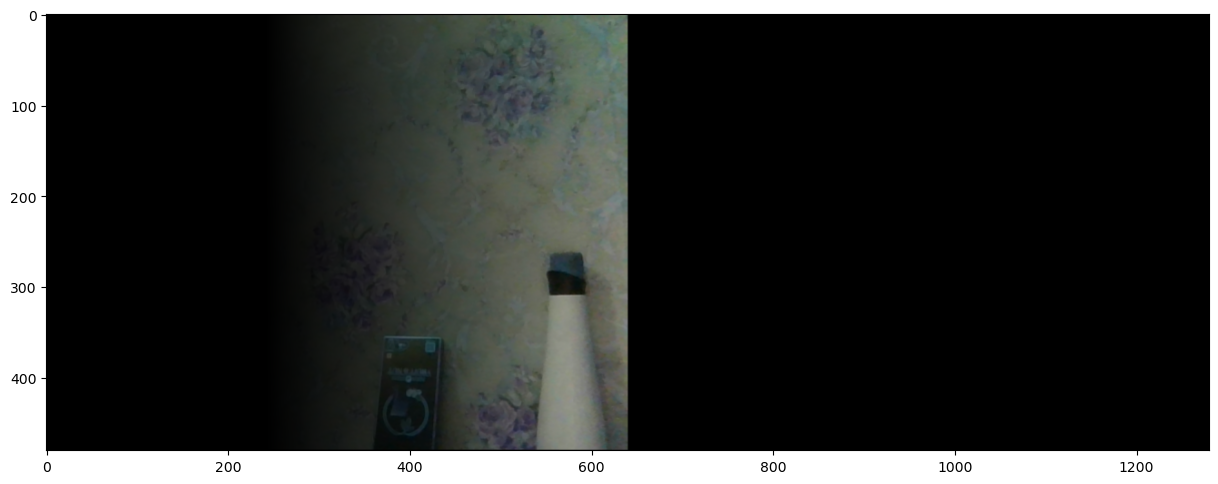

In [39]:
plt.figure(figsize=(15,10))
plt.imshow(panorama2/255.0)

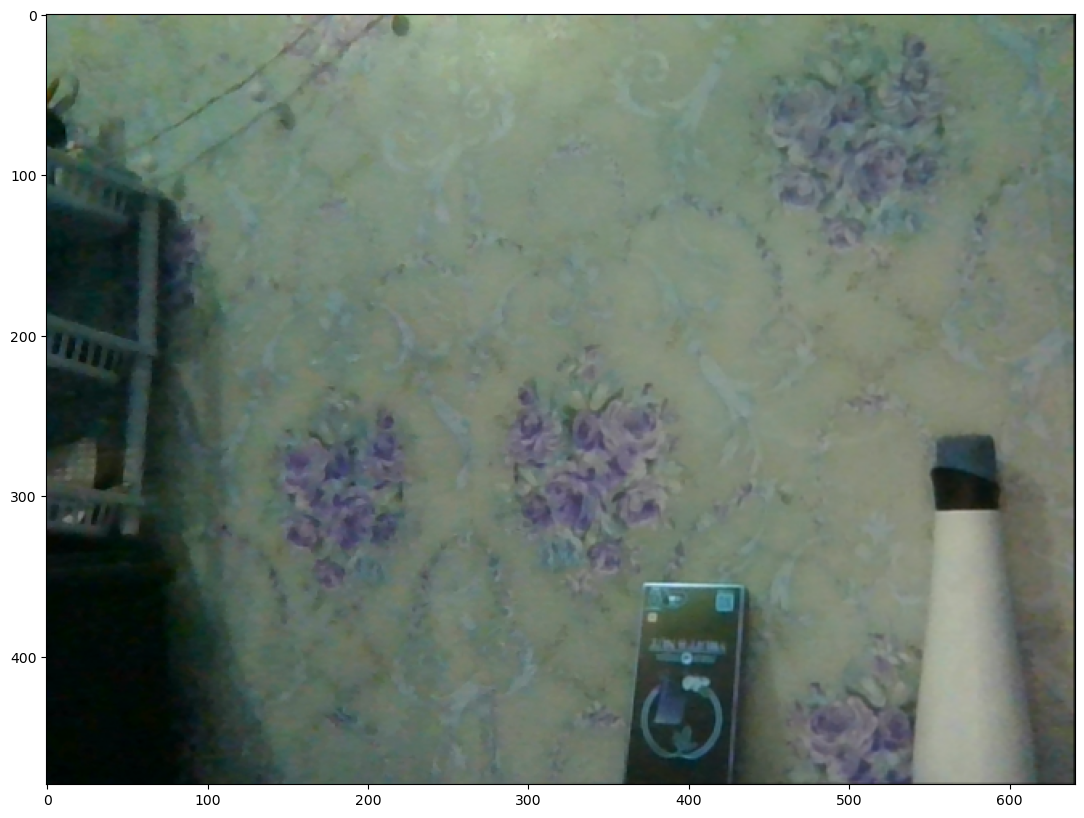

In [40]:
plt.figure(figsize=(15,10))
plt.imshow(final_result/255.0)

## Stitch Images using Functions

In [41]:
stitcher = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(images)

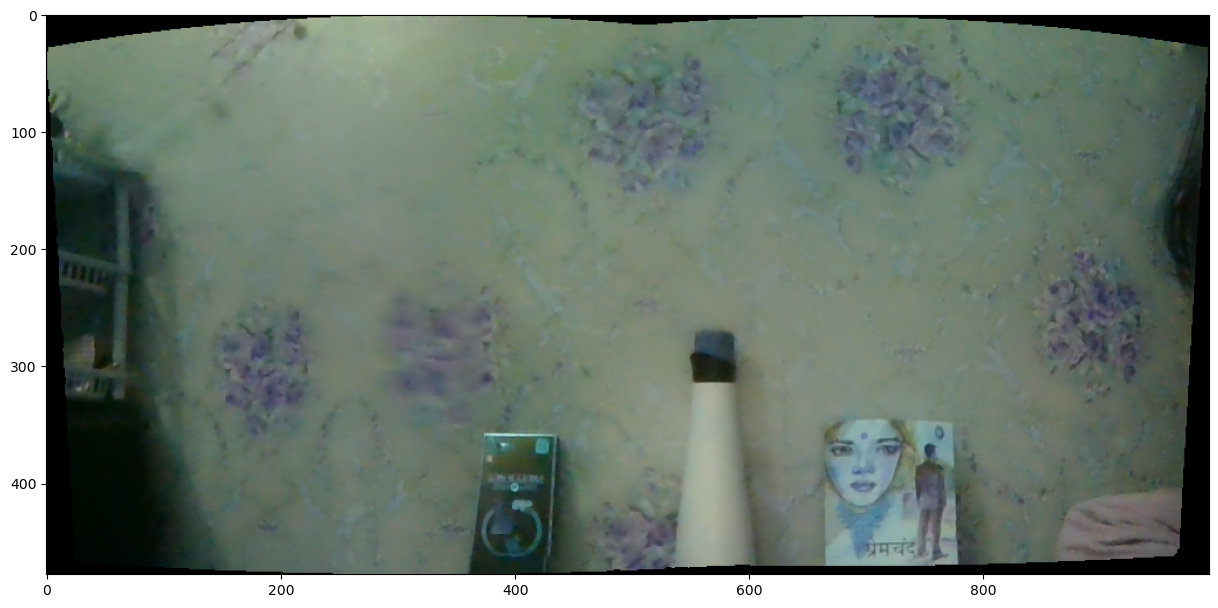

In [42]:
plt.figure(figsize=(15,10))
plt.imshow(stitched)